In [1699]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1700]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [1701]:
def collect_with_target_value(data_frame, column, target_value):
    collected_values = data_frame.loc[data_frame[column] == target_value]
    return collected_values

In [1702]:
active_df = collect_with_target_value(table, 'binding', 1).reset_index()
not_active_dfs = collect_with_target_value(table, 'binding',0).reset_index()

In [1703]:
not_active_dfs.shape

(722, 3)

In [1704]:
not_active_dfs = pd.DataFrame.sample(not_active_dfs,frac=.30, random_state= np.random.RandomState())
not_active_dfs.binding.shape

(217,)

In [1705]:
final_data_set = pd.concat([active_df,not_active_dfs])
final_data_set = final_data_set.drop(['index'],axis=1).sample(frac=1).reset_index()
final_data_set = final_data_set.drop(['index'],axis=1)

In [1706]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(table.sequence).reshape(-1,1),table.binding)

In [1707]:
final_data_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_data_set['binding'] = y_sampled
final_data_set.binding.value_counts()

0    722
1    722
Name: binding, dtype: int64

In [1708]:
from sklearn.model_selection import  train_test_split

training_split, test_split, train_result, test_result = train_test_split(final_data_set.sequence, final_data_set.binding,stratify=final_data_set.binding, train_size=.70, random_state=0)

In [1709]:
test_result.shape

(434,)

In [1710]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed
vectorizer, training_split = return_binary_vectorized_form(training_split)
test_split = vectorizer.transform(test_split).toarray()

In [1711]:
test_split

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [1712]:
train_result = np.array(train_result)
test_result = np.array(test_result)

In [1713]:
# training_sequence= []
# test_sequence = []
# for row in training_split:
#     training_sequence.append(str(row))
# for row in test_split:
#     test_sequence.append(str(row))


In [1714]:
training_split

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [1715]:
test_split
# training_sequence = np.array(training_sequence).reshape(1010)
# # test_sequence = np.array(test_sequence)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [1716]:
# training_sequence.s

In [1717]:
vocab_size = 40000
embedding_dim = 16
max_length = 1000
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [1718]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(training_sequence)
# word_index = tokenizer.word_index

In [1719]:
# sequences = tokenizer.texts_to_sequences(training_sequence)
# padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
# test_sequence = tokenizer.texts_to_sequences(test_sequence)
# testing_padded = pad_sequences(test_sequence, maxlen=max_length)
# padded

In [1720]:
training_split.shape[-1]

82145

In [1901]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(26,activation='relu',kernel_regularizer= tf.keras.regularizers.L1(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [1902]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=METRICS)

In [1903]:
num_epochs = 10
history = model.fit(training_split, train_result, epochs=num_epochs, validation_data=(test_split, test_result))

Epoch 1/10


/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-05 01:22:52.537576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 21.0688 - tp: 442.0000 - fp: 83.0000 - tn: 422.0000 - fn: 63.0000 - accuracy: 0.8554 - precision: 0.8419 - recall: 0.8752 - auc: 0.9365 - prc: 0.9432

2022-10-05 01:22:59.805328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 11s 249ms/step - loss: 21.0688 - tp: 442.0000 - fp: 83.0000 - tn: 422.0000 - fn: 63.0000 - accuracy: 0.8554 - precision: 0.8419 - recall: 0.8752 - auc: 0.9365 - prc: 0.9432 - val_loss: 6.8819 - val_tp: 163.0000 - val_fp: 6.0000 - val_tn: 211.0000 - val_fn: 54.0000 - val_accuracy: 0.8618 - val_precision: 0.9645 - val_recall: 0.7512 - val_auc: 0.9533 - val_prc: 0.9608
Epoch 2/10
32/32 [==============================] - 2s 69ms/step - loss: 5.4300 - tp: 442.0000 - fp: 22.0000 - tn: 483.0000 - fn: 63.0000 - accuracy: 0.9158 - precision: 0.9526 - recall: 0.8752 - auc: 0.9552 - prc: 0.9592 - val_loss: 4.8615 - val_tp: 194.0000 - val_fp: 7.0000 - val_tn: 210.0000 - val_fn: 23.0000 - val_accuracy: 0.9309 - val_precision: 0.9652 - val_recall: 0.8940 - val_auc: 0.9534 - val_prc: 0.9609
Epoch 3/10
32/32 [==============================] - 2s 69ms/step - loss: 4.6749 - tp: 436.0000 - fp: 13.0000 - tn: 492.0000 - fn: 69.0000 - accuracy: 0.9188 - precision: 0.

In [1878]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [1879]:
# unlabeled_test_sequence = []
# for row in table_test.sequence:
#     unlabeled_test_sequence.append(str(row))

In [1880]:
table_test

,sequence
0,259 521 546 565 671 769 858 876 1056 1252 1392...
1,96 158 195 436 518 541 588 642 804 843 978 115...
2,13 169 354 587 803 1241 1472 1586 1605 1638 16...
3,10 91 184 191 546 825 978 1077 1155 1220 1297 ...
4,37 85 119 191 349 390 437 458 671 707 1454 157...
...,...
345,43 150 273 363 797 889 1014 1016 1077 1176 135...
346,34 118 132 150 162 259 347 470 477 479 613 651...
347,84 250 263 616 1220 1289 1314 1384 1440 1442 1...
348,121 136 165 207 232 309 375 412 453 460 521 72...


In [1881]:
unlabeled_test_sequence = vectorizer.transform(table_test.sequence).toarray()

In [1882]:
unlabeled_test_sequence

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [1883]:
# unlabeled_test_sequence = tokenizer.texts_to_sequences(unlabeled_test_sequence)
# padded_unlabeled_test_sequence = pad_sequences(unlabeled_test_sequence, maxlen=max_length)

In [1884]:
y = model.predict(unlabeled_test_sequence)

11/11 [==============================] - 0s 11ms/step


In [1885]:
y

array([[0.78626114],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48656183],
       [0.5004774 ],
       [0.54764986],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.5052497 ],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.75659084],
       [0.5086178 ],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.5107806 ],
       [0.48406723],
       [0.5208573 ],
       [0.5409728 ],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.48406723],
       [0.484

In [1886]:

# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [1887]:
# from sklearn.metrics import f1_score
# print(f1_score(z,test_result))

In [1888]:
z[61]

1

In [1889]:
len(z)

350

In [1890]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()

In [1891]:
len(z)

350

In [1738]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [1739]:
import platform
platform.platform()

'macOS-12.6-arm64-arm-64bit'

In [1822]:
history.history

{'loss': [0.301663875579834,
  0.035479992628097534,
  0.019550293684005737,
  0.01685352809727192,
  0.015494161285459995,
  0.01466310489922762,
  0.014086703769862652,
  0.013661818578839302,
  0.01332317665219307,
  0.013051937334239483,
  0.012814955785870552,
  0.012613121420145035,
  0.012424757704138756,
  0.012253010645508766,
  0.012093325145542622,
  0.011941397562623024,
  0.011796226724982262,
  0.011653832159936428,
  0.011519316583871841,
  0.011395852081477642,
  0.011255133897066116,
  0.011130018159747124,
  0.011007022112607956,
  0.010883122682571411,
  0.010764174163341522,
  0.010643234476447105,
  0.010525164194405079,
  0.010410001501441002,
  0.010290988720953465,
  0.010177576914429665,
  0.010064639151096344,
  0.009957431815564632,
  0.00984199345111847,
  0.009733914397656918,
  0.0096231484785676,
  0.009515046142041683,
  0.00940966047346592,
  0.009302064776420593,
  0.009195619262754917,
  0.00909037422388792],
 'tp': [435.0,
  503.0,
  505.0,
  505.0,


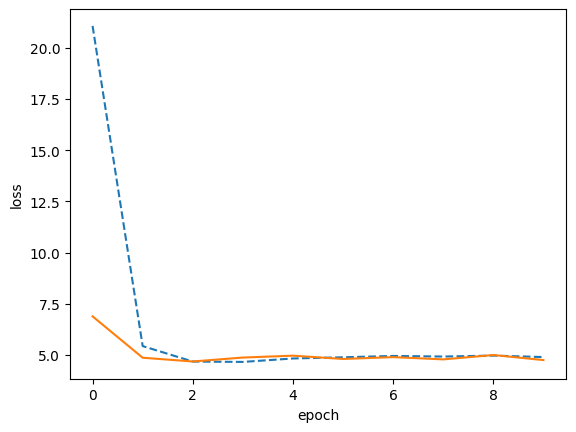

In [1904]:
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)
plt.plot(trainloss,'--')
plt.plot(testloss,'-')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

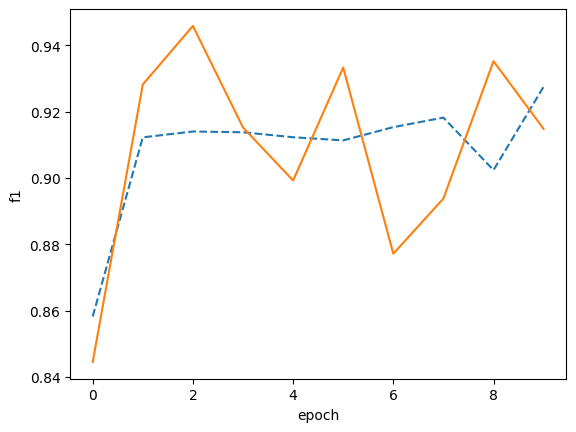

In [1905]:
ptest = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
ptrain= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j = 2 * ptrain * ptest / (ptrain+ptest)

ptest = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
ptrain= np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = 2 * ptrain * ptest / (ptrain+ptest)
plt.plot(j, '--')
plt.plot(k,'-')
plt.ylabel('f1')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()